In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import timm
import torch
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login
from uni import get_encoder

from torchvision import datasets, transforms
from torch.nn.functional import binary_cross_entropy
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from Classifier import Classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# setting the correct device to train on
torch.set_default_device(device)

In [4]:
encoder, transform = get_encoder(enc_name='uni2-h', device=device)

In [5]:
BATCH_SIZE = 12 # change smaller if running out of memory: [12,13) range for 16gb
                # [17,19) for 20gb

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

# Full dataset
dataset = datasets.ImageFolder(MAIN_PATH, transform = transform)

In [6]:
SPLIT = [55767, 6971, 6971] 

train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,      # 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [7]:
# Create the classifier
class_model = Classifier().to(device)

# Hyper paramaters
EPOCHS = 10
verbose = 1
LR = 4.3e-8
gamma = 0.02 # new_lr = lr * gamma, 0.3 much too big

optimizer = torch.optim.Adam([{'params': class_model.parameters(),'lr': LR}])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

optimizer, scheduler.gamma

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 4.3e-08
     lr: 4.3e-08
     maximize: False
     weight_decay: 0
 ),
 0.02)

In [ ]:
with open('progress.txt', 'w') as file:
    file.write(f"{class_model=}\n\nTraining:\n")

torch.autograd.set_detect_anomaly(True)

class_model.train()
loss_arr = []

for epoch in range(EPOCHS):
    count = 0
    for img, label in train_loader: 
        optimizer.zero_grad()

        img = img.to(device)
        label = label.to(device)
        
        features = encoder(img)
        
        pred = class_model(features)
        
        loss = binary_cross_entropy(pred, label.unsqueeze(dim=1).to(torch.float32))
        loss.backward()
        optimizer.step()
        if count % 1000 == 0 or count == len(train_loader) - 1:
            print(count*BATCH_SIZE)
        count += 1

    scheduler.step()
    
    loss_arr.append(loss.item())
    text = f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f}'
    print(text, end='\n'*2)
    with open('progress.txt', 'a') as file:
        file.write(f"{text}\n\n")
        
        
print('Finished Training')

In [ ]:
torch.save(class_model, f'./models/class_model.pth')

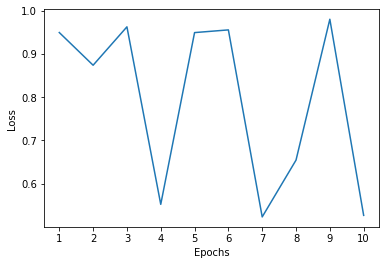

In [10]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()